In [ ]:
!pip install streamlit
!pip install ultralytics
!pip install timm
!pip install gtts
!pip install matplotlib

import cv2
import streamlit as st
import tempfile
import os
import numpy as np
from ultralytics import YOLO
import torch
import urllib.request
import matplotlib.pyplot as plt
from gtts import gTTS
import IPython.display as ipd
from google.colab import files
from io import BytesIO




def calculate_object_depth(depth_map, x_min, y_min, x_max, y_max, confidence,confidence_threshold=0.7):
    # Convert bounding box coordinates to integers
    x_min = int(x_min)
    y_min = int(y_min)
    x_max = int(x_max)
    y_max = int(y_max)

    # Check if confidence is above the threshold
    if confidence >= confidence_threshold:
        # Extract the depth values corresponding to the bounding box coordinates
        depth_values = depth_map[y_min:y_max, x_min:x_max]  # Assuming depth_map is a numpy array

        # Calculate the average depth value within the bounding box
        object_depth = np.mean(depth_values) if depth_values.size > 0 else 0  # Handling case where depth_values is empty

        return object_depth
    else:
        # If confidence is below the threshold, return None
        return 0

# Build a YOLOv9c model from pretrained weight
model = YOLO('yolov9c.pt')

#Build Midas DPT_Large model
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

# Set Streamlit app title
st.title("Image Path Example")

# Upload an image file
uploaded_image = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

# Process the uploaded image
if uploaded_image:
    # Read the image
    image_bytes = uploaded_image.read()
    image_array = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)

    # Save the image to a temporary file
    temp_dir = tempfile.gettempdir()
    temp_image_path = os.path.join(temp_dir, "uploaded_image.jpg")
    print(temp_image_path)
    cv2.imwrite(temp_image_path, image_array)


    # Display the image
    st.image(image_array, channels="BGR", caption="Uploaded Image", use_column_width=True)

    # Print the temporary image path
    st.write(f"Temporary image path: {temp_image_path}")

    # Read the image from the temp path
    image = cv2.imread(temp_image_path)




    results = model(image_array,imgsz=640, save=True)
    boxes = results[0].boxes.xyxy.tolist()
    classes = results[0].boxes.cls.tolist()
    names = results[0].names
    confidences = results[0].boxes.conf.tolist()

    for box, cls in zip(boxes, classes):
      x1, y1, x2, y2 = map(int, box)
      color = (0, 255, 0)  # Green color
      thickness = 1
      cv2.rectangle(image_array, (x1, y1), (x2, y2), color, thickness)
      class_name = names.get(cls, f"Class {cls}")
      cv2.putText(image_array, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


    st.image(image_array, channels="BGR", caption="Uploaded Image", use_column_width=True)

    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)
    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()


    depth_map = prediction.cpu().numpy()
    # print(depth_map)
    # st.pyplot(depth_map)

    # Assuming depth_map is your depth map data and objects_info is obtained from the previous code snippet
    depth_threshold = 24  # Define a threshold distance in meters

    # Iterate through each detected object
    for box, cls, confidence in zip(boxes, classes, confidences):
      # Extract bounding box coordinates
      x_min, y_min, x_max, y_max = box

      # Calculate the depth information for the object (you may need to adjust this based on your depth map format)
      object_depth = calculate_object_depth(depth_map, x_min, y_min, x_max, y_max,confidence)

      # Check if the object is too close based on the threshold distance
      if object_depth > depth_threshold:
        # Print a message indicating that the object is too close
        st.text(f"Warning! {names[cls]} is too close to you")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#u

100%|██████████| 49.4M/49.4M [00:00<00:00, 194MB/s]
/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing fro

In [ ]:
from ultralytics import YOLO

import cv2

In [ ]:
# Build a YOLOv9c model from pretrained weight
model = YOLO('yolov9c.pt')

In [ ]:
# Run inference with the YOLOv9c model on the 'bus.jpg' image
results = model('/content/OIP (1).jpg',imgsz=640, save=True)


image 1/1 /content/OIP (1).jpg: 448x640 5 persons, 1 car, 595.8ms
Speed: 1.6ms preprocess, 595.8ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [ ]:

import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [ ]:

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:

img = cv2.imread('/content/OIP (1).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

In [ ]:

depth_map

array([[     1.5054,      1.5494,      1.5791, ...,      2.2323,      2.2271,      2.2718],
       [     1.5702,      1.5957,      1.6366, ...,      2.2816,      2.3348,      2.3497],
       [     1.6008,      1.6261,      1.6647, ...,      2.3156,      2.3526,      2.3998],
       ...,
       [     23.413,      23.457,      23.481, ...,       24.38,       24.38,      24.396],
       [     23.547,      23.596,      23.637, ...,       24.52,      24.505,      24.509],
       [     23.715,      23.767,      23.779, ...,       24.61,       24.58,      24.557]], dtype=float32)

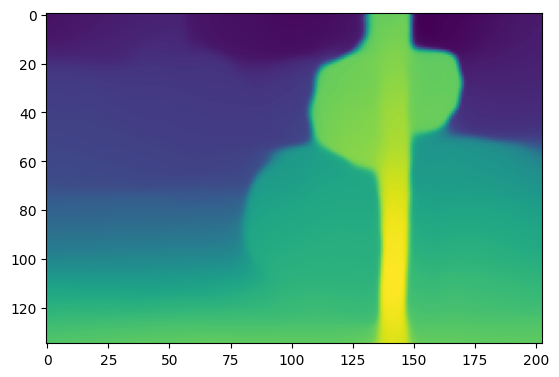

In [ ]:
plt.imshow(depth_map)
# plt.show()

In [ ]:

boxes = results[0].boxes.xyxy.tolist()
classes = results[0].boxes.cls.tolist()
names = results[0].names
confidences = results[0].boxes.conf.tolist()

In [ ]:
import numpy as np

def calculate_object_depth(depth_map, x_min, y_min, x_max, y_max, confidence_threshold=0.7):
    # Convert bounding box coordinates to integers
    x_min = int(x_min)
    y_min = int(y_min)
    x_max = int(x_max)
    y_max = int(y_max)

    # Check if confidence is above the threshold
    if confidence >= confidence_threshold:
        # Extract the depth values corresponding to the bounding box coordinates
        depth_values = depth_map[y_min:y_max, x_min:x_max]  # Assuming depth_map is a numpy array

        # Calculate the average depth value within the bounding box
        object_depth = np.mean(depth_values) if depth_values.size > 0 else 0  # Handling case where depth_values is empty

        return object_depth
    else:
        # If confidence is below the threshold, return None
        return 0


In [ ]:
# Assuming depth_map is your depth map data and objects_info is obtained from the previous code snippet
depth_threshold = 20  # Define a threshold distance in meters

# Iterate through each detected object
for box, cls, confidence in zip(boxes, classes, confidences):
    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = box

    # Calculate the depth information for the object (you may need to adjust this based on your depth map format)
    object_depth = calculate_object_depth(depth_map, x_min, y_min, x_max, y_max)

    # Check if the object is too close based on the threshold distance
    if object_depth > depth_threshold:
        # Print a message indicating that the object is too close
        print(f"Object of class {names[cls]} is too close at depth")
    # else:
    #   print(object_depth," ",names[cls])

Object of class car is too close at depth


In [ ]:
from gtts import gTTS
import IPython.display as ipd

# Process each object
for box, cls, confidence in zip(boxes, classes, confidences):
    x_min, y_min, x_max, y_max = box
    object_depth = calculate_object_depth(depth_map, x_min, y_min, x_max, y_max, confidence)

    if object_depth > depth_threshold:
        warning_text = f"Warning! {names[cls]} is too close."
        st.text(warning_text)

        # Generate and play audio output
        tts = gTTS(warning_text, lang='en')
        tts.save("warning.mp3")
        ipd.display(ipd.Audio("warning.mp3", autoplay=True))


2024-12-02 07:48:06.344 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-02 07:48:06.345 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existi

In [ ]:

import gradio as gr

# Load YOLO model
model = YOLO('yolov9c.pt')

# Load MiDaS model
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if model_type in ["DPT_Large", "DPT_Hybrid"] else midas_transforms.small_transform

def calculate_object_depth(depth_map, x_min, y_min, x_max, y_max, confidence, confidence_threshold=0.7):
    x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
    if confidence >= confidence_threshold:
        depth_values = depth_map[y_min:y_max, x_min:x_max]
        return np.mean(depth_values) if depth_values.size > 0 else 0
    return 0

def process_image(image):
    # Run YOLO model
    results = model(image, imgsz=640)
    boxes = results[0].boxes.xyxy.tolist()
    classes = results[0].boxes.cls.tolist()
    names = results[0].names
    confidences = results[0].boxes.conf.tolist()

    # Prepare depth map
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_batch = transform(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1), size=img_rgb.shape[:2], mode="bicubic", align_corners=False
        ).squeeze()
    depth_map = prediction.cpu().numpy()

    # Annotate image with bounding boxes
    annotated_image = image.copy()
    depth_threshold = 20  # meters
    audio_output = None

    for box, cls, confidence in zip(boxes, classes, confidences):
        x_min, y_min, x_max, y_max = box
        object_depth = calculate_object_depth(depth_map, x_min, y_min, x_max, y_max, confidence)
        color = (0, 255, 0)  # Green for bounding boxes
        cv2.rectangle(annotated_image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 2)
        label = f"{names[cls]}: {object_depth:.2f}m"
        cv2.putText(annotated_image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        if object_depth > depth_threshold:
            warning_text = f"Warning! {names[cls]} is too close."
            tts = gTTS(warning_text, lang='en')
            tts.save("warning.mp3")
            audio_output = "warning.mp3"

    return annotated_image, depth_map, audio_output

def gui_interface(image):
    annotated_image, depth_map, audio_output = process_image(image)

    # Prepare depth map for visualization
    depth_map_visual = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    depth_map_visual = cv2.applyColorMap(depth_map_visual, cv2.COLORMAP_JET)

    return annotated_image, depth_map_visual, audio_output

# Gradio interface
interface = gr.Interface(
    fn=gui_interface,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=[
        gr.Image(type="numpy", label="Annotated Image"),
        gr.Image(type="numpy", label="Depth Map"),
        gr.Audio(label="Warning Audio")
    ],
    title="Depth and Object Detection"
)

interface.launch()

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d048d8d5a88442cbd7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
